In [1]:
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
class WrightFisher():
    """
    Haploid Wright-Fisher model
    
    Parameters:
    N: population size
    s: selection coefficient
    n: initial variant allele count
    """
    def __init__(self, N, s = 0, n = 1):
        # Set population size, selection coefficient and allele count for A
        self.N = N
        self.s = s
        self.n = n
        
        # Set initial allele frequencies
        self.p0 = self.n/self.N
        self.q0 = self.N - self.p0
        
        # Set fitnesses relative to selection
        self.wa = 1 + s
        self.wA = 1
        
    # Run Wright-Fisher simulation for a single site
    def simulateSingleSite(self, max_generations):
        # Create array of population alleles per generation
        population_alleles = np.zeros(max_generations + 1, dtype = int)
        # Set allele counts for initial generation
        population_alleles[0] = self.n
        
        # Initialise counters
        gen = 0
        allele_count = self.n
        max_allele_counts = self.n
        
        # Repeat for n generations
        while (gen < max_generations and 0 < allele_count < self.N + 1):
            gen += 1
            
            # Get the allele count in the previous generation
            allele_count = population_alleles[gen - 1]
            # Calculate probability of sampling the allele 
            prob = allele_count * (1 + self.s) / (allele_count * (1 + self.s) + self.N - allele_count)
            
            # Simulate number of copies in next generation
            population_alleles[gen] = np.random.binomial(n = self.N,
                                                         p = prob)
        
        return population_alleles
        
    def initialiseTwoLoci(self, distribution):
        site_distribution = distribution[2:-2]
        
        # Population allele counts
        alleles = {"AB": 0, "Ab": 0, "aB": 0, "ab": 0}

        # Calculate probability of samples allele count between 2 to N - 2
        prob = site_distribution / sum(site_distribution)

        A_allele_count = np.random.choice(a = range(2, len(site_distribution) + 2), p = prob)
        a_allele_count = self.N - A_allele_count

        # Randomly introduce a singleton at a loci
        singleton_A = np.random.choice(["A", "a"])
        singleton_B = np.random.choice(["B", "b"])

        if singleton_B == "B":
            B_allele_count = 1
            b_allele_count = self.N - 1
        else:
            B_allele_count = self.N - 1
            b_allele_count = 1

        # Record the singleton
        alleles[singleton_A + singleton_B] = 1

        # Set the remaining allele counts
        if singleton_A + singleton_B == "AB":
            alleles["Ab"] = A_allele_count - 1
            alleles["aB"] = B_allele_count - alleles["AB"]
            alleles["ab"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "Ab":
            alleles["AB"] = A_allele_count - 1
            alleles["ab"] = b_allele_count - alleles["Ab"]
            alleles["aB"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "aB":
            alleles["AB"] = B_allele_count - 1
            alleles["Ab"] = A_allele_count - alleles["AB"]
            alleles["ab"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "ab":
            alleles["AB"] = A_allele_count
            alleles["Ab"] = b_allele_count - alleles["ab"]
            alleles["aB"] = self.N - sum(alleles.values())
            
        # Return the population genomes and allele frequencies
        return {"alleles": alleles,
                "allele_counts": {"A": A_allele_count,
                                  "a": a_allele_count,
                                  "B": B_allele_count,
                                  "b": b_allele_count},
                "singleton_haploid": singleton_A + singleton_B}
    
    # Calculate D' and r^2 LD statistics
    def linkageDisequilibrium (self, alleles, allele_counts, singleton_haploid):
        # Calculate proportion of individuals with an allele at each locus, i.e. pA, pa, pB, pb
        allele_probabilities = dict(zip(["p" + i for i in allele_counts.keys()],
                                        [allele_counts[j] / 100 for j in allele_counts.keys()]))
        # Proportion of two alleles occuring at the two loci, i.e. pAB, pAb, paB, pab
        haploid_probabilities = dict(zip(["p" + i for i in alleles.keys()],
                                         [alleles[j] / 100 for j in alleles.keys()]))

        # Calculate coefficient of linkage disequilibrium for each haplotype
        D_haplotype = {"AB": haploid_probabilities["pAB"] - (allele_probabilities["pA"] * allele_probabilities["pB"]),
                       "Ab": haploid_probabilities["pAb"] - (allele_probabilities["pA"] * allele_probabilities["pb"]),
                       "aB": haploid_probabilities["paB"] - (allele_probabilities["pa"] * allele_probabilities["pB"]),
                       "ab": haploid_probabilities["pab"] - (allele_probabilities["pa"] * allele_probabilities["pb"])}

        # Calculate normalised D by dividing by the maximum difference between observed and expected haplotype frequencies
        D_normalised = D_haplotype[singleton_haploid] / max(D_haplotype.values())

        # Calculate genetric correlation coefficient between pairs of loci
        r2 = (D_haplotype[singleton_haploid] ** 2) / (allele_probabilities["p" + singleton_haploid[0]] *
                                                      (1 - allele_probabilities["p" + singleton_haploid[0]]) *
                                                      allele_probabilities["p" + singleton_haploid[1]] *
                                                      (1 - allele_probabilities["p" + singleton_haploid[1]]))
        
        return D_normalised, r2
    
    # Plot distribution of maximum allele count
    def plotMaxAllele(self, max_allele_counts,
                      title = "Distribution of Maximum Allele Number Reached ($\mathregular{M_i}$)"):
        max_allele_fig = plt.figure(figsize = (10, 5))
        max_allele_hist = plt.hist(max_allele_counts,
                                   color = "orange",
                                   edgecolor = "black", 
                                   linewidth = 1.2,
                                   bins = min(max(max_allele_counts), 100))
        plt.xlabel("Maximum Allele Number ($\mathregular{M_i}$)") 
        plt.ylabel("Number of Simulations") 
        plt.title(title)
        plt.show()
        
        return max_allele_fig
        
    # Plot distribution of time for simulations where the variant fixes or is lost
    def plotTime(self, fixation_times, loss_times, combine_plots = False,
                 title = "Distribution of Time Steps ($\mathregular{T_i}$) for the Allele to Fix or be Lost"):
        
        # Check whether to plot data on the same axis
        if combine_plots:
            time_hist_fig = plt.figure(figsize = (10, 5))
            # Plot fixation histogram
            plt.hist(fixation_times, color = "lime", label = "Fixed",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            # Also plot loss histogram on same axis
            plt.hist(loss_times, color = "red", label = "Lost",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            plt.xlabel("Time ($\mathregular{T_i}$)") 
            plt.ylabel("Number of Simulations")
            plt.title(title)
            plt.legend(loc = "upper right")
            
        # Otherwise create subplots
        else:
            time_hist_fig, axes = plt.subplots(1, 2, figsize = (12, 5))
            axes[0].hist(fixation_times, color = "lime", label = "Fixed",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[1].hist(loss_times, color = "red", label = "Lost",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[0].title.set_text("Fixation")
            axes[1].title.set_text("Loss")
            time_hist_fig.suptitle(title, y = 1.03)
            
            for ax in axes:
                ax.set_xlabel("Time ($\mathregular{T_i}$)")
                ax.set_ylabel("Number of Simulations")
            
        plt.show()
        
        return time_hist_fig
    
    # Plot density heatmap of allele counts over time
    def plotPathDensity(self, path_density, title = "Path Density", 
                        fontsize = 12, cmap = "viridis",
                        logscale = True, add_expected = False,
                        expected_colour = "white"):
        
        # Create figure
        density_fig, ax = plt.subplots(figsize = (11, 9))
        # Log the data if logscale set as True
        density_data = np.log(path_density + 1) if logscale else path_density
        
        # Add density heatmap of allele counts over time
        heatmap = ax.imshow(density_data, cmap = cmap, aspect = "auto")
        
        # Flip the y-axis so n increases upwards
        ax.set_ylim(ax.get_ylim()[::-1])
        
        # Add colour bar
        colour_bar = density_fig.colorbar(heatmap, pad = 0.15 if add_expected else 0.05)
        colour_bar_label = "Log(Density + 1)" if logscale else "Density"
        colour_bar.ax.set_title(colour_bar_label, fontsize = 10)

        if add_expected:
            # Create sigmoid expectation curve for p(t) under the deterministic, no drift model
            t = np.linspace(0, len(simulation_results["path_density"][0]) - 1,
                            num = len(simulation_results["path_density"][0]))
            n = 1/(1 + ((self.q0/self.p0) * ((self.wA / self.wa) ** t)))
            
            # Plot curve on top
            ax2 = plt.twinx()
            sns.lineplot(x = t, y = n, linewidth = 3, ax = ax2, color = expected_colour)
            ax.axis('tight')
            ax2.set_ylabel("Expected p(t) with no Drift", fontsize = fontsize)
        
        ax.set_xlabel("Time (t)", fontsize = fontsize)
        ax.set_ylabel("Allele Count (n)", fontsize = fontsize)
        ax.set_title(title, fontsize = fontsize + 2)
        plt.show()
        
        return density_fig
        
    # Plot distribution of number of copies of an allele over all generations
    def plotAlleleCount(self, all_allele_counts, logscale = True,
                        title = "Distribution of Total Allele Copies Across Generations S(n)"):
        allele_counts_fig = plt.figure(figsize = (10, 5))
        allele_counts_bar = plt.bar(range(len(all_allele_counts)),
                                    all_allele_counts,
                                    color = "skyblue",
                                    edgecolor = "black", 
                                    linewidth = 1.2)
        plt.xlabel("Allele Count (n)") 
        plt.ylabel("Frequency")
        plt.title(title)
        plt.yscale("log" if logscale else "linear")
        plt.show()
        
        return allele_counts_fig
    
    def repeatSimulate(self, max_generations = 500, n_times = 1000):
        # The highest numbers the allele reaches per simulation
        max_allele_counts = np.zeros(n_times, dtype = int)
        # The times taken for the allele to fix or be lost
        end_times = np.zeros(n_times, dtype = int)
        # Density of allele counts over time for n simulations
        path_density = np.zeros((self.N + 1, max_generations), dtype = int)
        
        # Total time for simulations that fix and loose the allele
        fixation_times = np.array([])
        loss_times = np.array([])
        fluctuating_times = np.array([])
        # Average time for simulations that fix and loose the allele
        mean_fixation_time = None
        mean_loss_time = None
        
        # Run the simulation n times
        for i in range(n_times):
            # Run Wright-Fisher model
            population_alleles = self.simulateSingleSite(max_generations)
            # Get the maximum allele count and simulation end time
            max_allele_counts[i] = max(population_alleles)
            end_times[i] = len(population_alleles[population_alleles != 0])
            
            # Increment path density for the new allele counts over time
            for j in range(1, len(population_alleles)):
                path_density[population_alleles[j]][j - 1] += 1
                
            # Check if allele fixes
            if population_alleles[-1] == self.N:
                # Add time when allele fixes
                fixation_times = np.append(fixation_times,
                                           np.where(population_alleles == self.N)[0][0])
            elif population_alleles[-1] == 0:
                # Add time taken for allele to be lost
                loss_times = np.append(loss_times, end_times[i])
                
        # Number of simulations in which the allele fixes, is lost or still fluctuating
        n_fixed = len(fixation_times)
        n_lost = len(loss_times)
        n_fluctuating = n_times - n_fixed - n_lost
        
        # Calculate average fixation and loss time
        if n_fixed > 0:
            mean_fixation_time = sum(fixation_times) / len(fixation_times)
        if n_lost > 0:
            mean_loss_time = sum(loss_times) / len(loss_times)
            
        # S(n) distribution, i.e. number of copies of the variant alelle over all generations
        all_allele_counts = np.array([sum(row) for row in path_density])
        
        return {"max_allele_counts": max_allele_counts,
                "end_times": end_times,
                "path_density": path_density,
                "n_fixed": n_fixed,
                "n_lost": n_lost,
                "n_fluctuating": n_fluctuating,
                "mean_fixation_time": mean_fixation_time,
                "mean_loss_time": mean_loss_time,
                "fixation_times": fixation_times,
                "loss_times": loss_times,
                "all_allele_counts": all_allele_counts}

Fixed 14 times
Lost 984 times
Fluctuating 2 times
Average fixation time of 184.929
Average loss time of 8.633


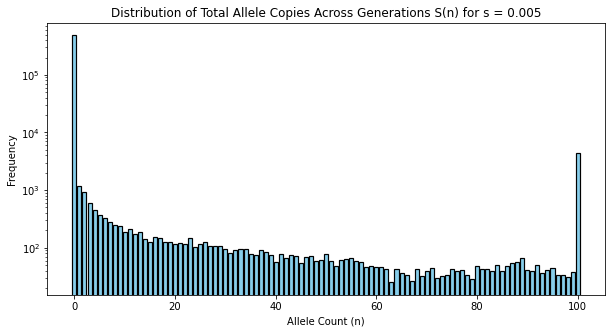

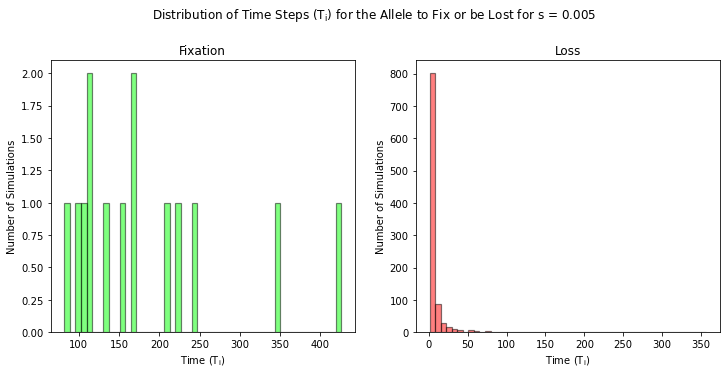

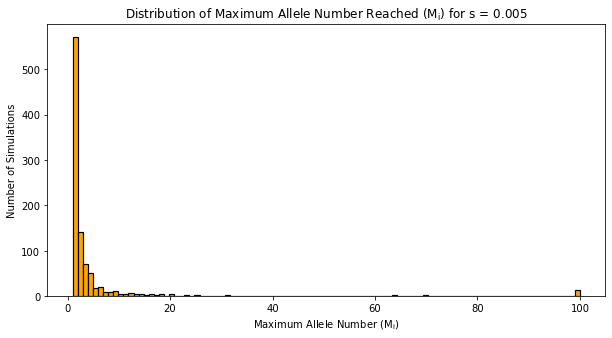

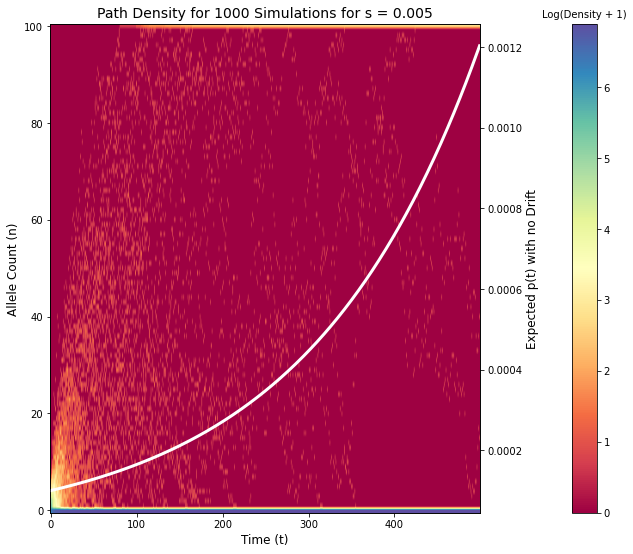

In [3]:
selection_coefficient = 0.005

# Run the simulator
wf_simulator = WrightFisher(N = 100, s = selection_coefficient)
simulation_results = wf_simulator.repeatSimulate(n_times = 1000)

# Print summary statistics
print("Fixed " + str(simulation_results["n_fixed"]) + " times")
print("Lost " + str(simulation_results["n_lost"]) + " times")
print("Fluctuating " + str(simulation_results["n_fluctuating"]) + " times")
if simulation_results["mean_fixation_time"] != None:
    print("Average fixation time of " + str(round(simulation_results["mean_fixation_time"], 3)))
print("Average loss time of " + str(round(simulation_results["mean_loss_time"], 3)))

# Add s to plot titles and file names if s not zero
extra_title = " for s = " + str(selection_coefficient) if selection_coefficient != 0 else ""
extra_file_name = "_s=" + str(selection_coefficient) if selection_coefficient != 0 else ""

# Plot results
allele_count_bar = wf_simulator.plotAlleleCount(simulation_results["all_allele_counts"], logscale = True,
                                               title = "Distribution of Total Allele Copies Across Generations S(n)" + extra_title)
time_bars = wf_simulator.plotTime(simulation_results["fixation_times"], simulation_results["loss_times"],
                                 title = "Distribution of Time Steps ($\mathregular{T_i}$) for the Allele to Fix or be Lost" + extra_title)
max_allele_hist = wf_simulator.plotMaxAllele(simulation_results["max_allele_counts"],
                                            title = "Distribution of Maximum Allele Number Reached ($\mathregular{M_i}$)" + extra_title)
density_plot = wf_simulator.plotPathDensity(simulation_results["path_density"], 
                                            cmap = "Spectral", logscale = True,
                                            title = "Path Density for 1000 Simulations" + extra_title,
                                            add_expected = True if selection_coefficient != 0 else False)

# Save plots
allele_count_bar.savefig("Allele_Count_Bar" + extra_file_name + ".pdf", bbox_inches = "tight")
time_bars.savefig("Time_Bars" + extra_file_name + ".pdf", bbox_inches = "tight")
max_allele_hist.savefig("Max_Allele_Histogram" + extra_file_name + ".pdf", bbox_inches = "tight")
density_plot.savefig("Path_Density" + extra_file_name + ".pdf", bbox_inches = "tight")

In [27]:
np.random.choice(a = range(2, len(sd) + 2), p = prob)
range(2, len(sd) + 2)

range(2, 99)

In [4]:
ld_d = np.zeros(1000)
ld_r2 = np.zeros(1000)

In [ ]:
0.494949494949495
{'AB': 1, 'Ab': 1, 'aB': 0, 'ab': 98}
{'A': 2, 'a': 98, 'B': 1, 'b': 99}

In [25]:
alleles

{'AB': 2, 'Ab': 0, 'aB': 97, 'ab': 1}

In [17]:
wf_simulator2 = WrightFisher(N = 100, s = 0)

for i in range(1000):
    # 
    simulation_results2 = wf_simulator.repeatSimulate(n_times = 100)
    initial_loci = wf_simulator2.initialiseTwoLoci(simulation_results2["all_allele_counts"])

    alleles = initial_loci["alleles"]
    allele_counts = initial_loci["allele_counts"]
    singleton_haploid = initial_loci["singleton_haploid"]

    ld_d[i], ld_r2[i] = wf_simulator2.linkageDisequilibrium(alleles, allele_counts, singleton_haploid)

In [21]:
def plotRSquared(r2_values):
    fig = plt.figure(figsize = (10, 5))
    plt.hist(r2_values, color = "blue", edgecolor = "black", bins = 100)

    # Add labels
    plt.title("Initial $r^{2}$ for 1000 Simulations")
    plt.xlabel("$r^{2}$")
    plt.ylabel("Number of Simulations")
    
    return fig

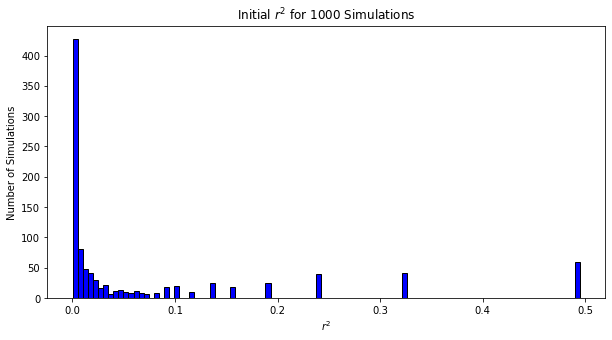

In [29]:
r2_histogram = plotRSquared(ld_r2)

# Save plot
r2_histogram.savefig("r2_Initial_Distribution.pdf", bbox_inches = "tight")

Text(0, 0.5, 'Number of Simulations')

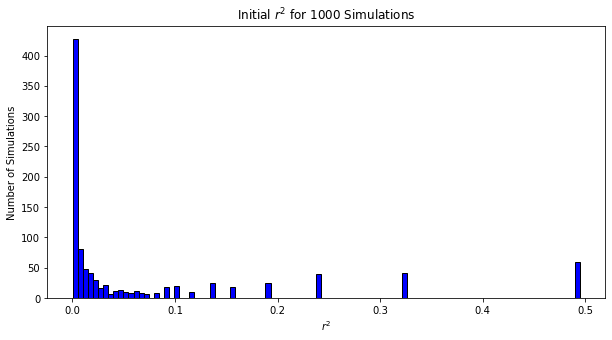

In [18]:
fig = plt.figure(figsize = (10, 5))
plt.hist(ld_r2, color = "blue", edgecolor = "black", bins = 100)

# Add labels
plt.title("Initial $r^{2}$ for 1000 Simulations")
plt.xlabel("$r^{2}$")
plt.ylabel("Number of Simulations")

# Save plot
allele_count_bar.savefig("Allele_Count_Bar" + extra_file_name + ".pdf", bbox_inches = "tight")

In [16]:
ld_d

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
wf_simulator2.linkageDisequilibrium(alleles, allele_counts, singleton_haploid)

(1.0, 0.0035490035490035486)

In [ ]:
# Calculate proportion of individuals with an allele at each locus, i.e. pA, pa, pB, pb
allele_probabilities = dict(zip(["p" + i for i in allele_counts.keys()],
                                [allele_counts[j] / 100 for j in allele_counts.keys()]))
# Proportion of two alleles occuring at the two loci, i.e. pAB, pAb, paB, pab
haploid_probabilities = dict(zip(["p" + i for i in alleles.keys()],
                                 [alleles[j] / 100 for j in alleles.keys()]))

# Calculate coefficient of linkage disequilibrium for each haplotype
D_haplotype = {"AB": haploid_probabilities["pAB"] - (allele_probabilities["pA"] * allele_probabilities["pB"]),
               "Ab": haploid_probabilities["pAb"] - (allele_probabilities["pA"] * allele_probabilities["pb"]),
               "aB": haploid_probabilities["paB"] - (allele_probabilities["pa"] * allele_probabilities["pB"]),
               "ab": haploid_probabilities["pab"] - (allele_probabilities["pa"] * allele_probabilities["pb"])}

# Calculate normalised D by dividing by the maximum difference between observed and expected haplotype frequencies
D_normalised = D_haplotype[singleton_haploid] / max(D_haplotype.values())
    
# Calculate correlation coefficient between pairs of loci
r2 = (D_haplotype[singleton_haploid] ** 2) / (allele_probabilities["pA"] * (1 - allele_probabilities["pA"]) *
                                              allele_probabilities["pB"] * (1 - allele_probabilities["pB"]))
    
D_normalised

In [ ]:
np.random.multinomial(n = 100, pvals = [0.1,0.2,0.6, 0.1])

In [ ]:
r = 0.02
s = 0

N = 100

allele_fixed = False
current_alleles = alleles

while not allele_fixed:

    new_alleles = {"AB": 0, "Ab": 0, "aB": 0, "ab": 0}

    # Form a new population
    for i in range(N):
        
        # Probability of each haplotype being selected
        selection_probability = np.array(list(current_alleles.values())) / N
        # Add selection coefficient and normalise
        selection_probability + np.array([s, s, -s, -s])
        selection_probability = [i/sum(selection_probability)
                                 for i in selection_probability]
        
        # Randomly select a haplotype from the population
        individual = np.random.choice(list(current_alleles.keys()),
                                      p = selection_probability)

        # No recombination
        if np.random.uniform() > r:
            # Offspring is the same as the individual in the next generation
            new_alleles[individual] += 1

        # Make a recombinant haplotype
        else:
            # Randomly select an allele to keep
            allele_1 = np.random.choice(list(individual))

            # If A loci, randomly select a B allele from the population
            if allele_1.lower() == "a":
                allele_2 = np.random.choice(["B", "b"],
                                            p = np.array([allele_counts["B"],
                                                          allele_counts["b"]]) / N)
                # Form the new recombinant haplotype
                offspring = allele_1 + allele_2

            # Otherwise randomly select an A allele from the population
            else:
                allele_2 = np.random.choice(["A", "a"],
                                            p = np.array([allele_counts["A"],
                                                          allele_counts["a"]]) / N)
                offspring = allele_2 + allele_1

            # Add the recombinant offspring to the population
            new_alleles[offspring] += 1

    print(new_alleles)

    new_allele_counts = {"A": new_alleles["AB"] + new_alleles["Ab"],
                     "a": new_alleles["aB"] + new_alleles["ab"],
                     "B": new_alleles["AB"] + new_alleles["aB"],
                     "b": new_alleles["Ab"] + new_alleles["ab"]}
    
    # Check if any of the alleles have fixed
    if N in new_allele_counts.values():
        allele_fixed = True
        
    current_alleles = new_alleles

In [ ]:
new_allele_counts = {"A": new_alleles["AB"] + new_alleles["Ab"],
                     "a": new_alleles["aB"] + new_alleles["ab"],
                     "B": new_alleles["AB"] + new_alleles["aB"],
                     "b": new_alleles["Ab"] + new_alleles["ab"]}

print(new_allele_counts)

# Check if any of the alleles have fixed
if 100 in new_allele_counts.values():
    print("y")